In [2]:
fid_scores = []

In [34]:
x_labels = [20, 40, 60, 80, 100, 120, 140, 160, 180, 200,220,240,260,280,300,320,340,360,380,400,420,440,450]
fid_scores_check=[536.3427,528.8147,334.8645,237.7244,189.0731,156.0186,123.9641,150.4747,104.0368,118.1628,109.8486,125.0839,103.4686,103.6484,105.4342,106.8002,94.8336,100.9144,108.8136,88.6363,89.4887,93.6709,90.1272]

In [4]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from torch.utils.data import DataLoader
from PIL import Image
import os
import numpy as np
from tqdm import tqdm
from scipy.linalg import sqrtm

# ===== CẤU HÌNH =====
real_path = "/kaggle/input/data-normal/NORMAL/NORMAL"
fake_path = "/kaggle/working/fake_top150_1"
batch_size = 32
image_size = 224
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ===== TIỀN XỬ LÝ ẢNH =====
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Ảnh X-ray sang RGB
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
])

def load_images(folder):
    imgs = []
    for file in os.listdir(folder):
        if file.lower().endswith((".jpg", ".png", ".jpeg")):
            img = Image.open(os.path.join(folder, file)).convert("L")
            img = transform(img)
            imgs.append(img)
    return torch.stack(imgs)

# ===== MẠNG TRÍCH ĐẶC TRƯNG: RESNET18 (lấy trước tầng fc) =====
class ResNetFeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        resnet = models.resnet18(pretrained=True)
        self.features = nn.Sequential(*list(resnet.children())[:-1])  # Bỏ tầng fc

    def forward(self, x):
        with torch.no_grad():
            x = self.features(x)
            return x.view(x.size(0), -1)

# ===== TÍNH MEAN & COVARIANCE =====
def calculate_stats(dataloader, model):
    features = []
    for imgs in tqdm(dataloader):
        imgs = imgs.to(device)
        feats = model(imgs)
        features.append(feats.cpu().numpy())
    features = np.concatenate(features, axis=0)
    mu = np.mean(features, axis=0)
    sigma = np.cov(features, rowvar=False)
    return mu, sigma

# ===== TÍNH FID TAY =====
def calculate_fid(mu1, sigma1, mu2, sigma2, eps=1e-6):
    covmean, _ = sqrtm(sigma1 @ sigma2, disp=False)
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid = np.sum((mu1 - mu2) ** 2) + np.trace(sigma1 + sigma2 - 2 * covmean)
    return fid

# ===== CHẠY TÍNH FID =====
real_images = load_images(real_path)
fake_images = load_images(fake_path)

real_loader = DataLoader(real_images, batch_size=batch_size)
fake_loader = DataLoader(fake_images, batch_size=batch_size)

model = ResNetFeatureExtractor().to(device).eval()

mu1, sigma1 = calculate_stats(real_loader, model)
mu2, sigma2 = calculate_stats(fake_loader, model)

fid_score = calculate_fid(mu1, sigma1, mu2, sigma2)
print(f"FID (ResNet18): {fid_score:.4f}")
#fid_scores.append(fid_score)

100%|██████████| 5/5 [00:00<00:00, 51.74it/s]


FID (ResNet18): 75.5569


In [3]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from torch.utils.data import DataLoader
from PIL import Image
import os
import numpy as np
from tqdm import tqdm
from scipy.linalg import sqrtm

# ===== CẤU HÌNH =====
real_path = "/kaggle/input/data-normal/NORMAL/NORMAL"
fake_path = "/kaggle/input/epochs-400-10k"
batch_size = 32
image_size = 224
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ===== TIỀN XỬ LÝ ẢNH =====
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Ảnh X-ray sang RGB
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
])

def load_images(folder):
    imgs = []
    for file in os.listdir(folder):
        if file.lower().endswith((".jpg", ".png", ".jpeg")):
            img = Image.open(os.path.join(folder, file)).convert("L")
            img = transform(img)
            imgs.append(img)
    return torch.stack(imgs)

# ===== MẠNG TRÍCH ĐẶC TRƯNG: RESNET18 (lấy trước tầng fc) =====
class ResNetFeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        resnet = models.resnet18(pretrained=True)
        self.features = nn.Sequential(*list(resnet.children())[:-1])  # Bỏ tầng fc

    def forward(self, x):
        with torch.no_grad():
            x = self.features(x)
            return x.view(x.size(0), -1)

# ===== TÍNH MEAN & COVARIANCE =====
def calculate_stats(dataloader, model):
    features = []
    for imgs in tqdm(dataloader):
        imgs = imgs.to(device)
        feats = model(imgs)
        features.append(feats.cpu().numpy())
    features = np.concatenate(features, axis=0)
    mu = np.mean(features, axis=0)
    sigma = np.cov(features, rowvar=False)
    return mu, sigma

# ===== TÍNH FID TAY =====
def calculate_fid(mu1, sigma1, mu2, sigma2, eps=1e-6):
    covmean, _ = sqrtm(sigma1 @ sigma2, disp=False)
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid = np.sum((mu1 - mu2) ** 2) + np.trace(sigma1 + sigma2 - 2 * covmean)
    return fid

# ===== CHẠY TÍNH FID =====
# ===== Trích đặc trưng ảnh thật và tính mean =====
real_images = load_images(real_path)
real_loader = DataLoader(real_images, batch_size=batch_size)
model = ResNetFeatureExtractor().to(device).eval()

# Tính đặc trưng của ảnh thật
real_feats = []
for imgs in tqdm(real_loader, desc="Real features"):
    imgs = imgs.to(device)
    feats = model(imgs)
    real_feats.append(feats.cpu().numpy())
real_feats = np.concatenate(real_feats, axis=0)

# Tính mean đặc trưng ảnh thật
real_mean = np.mean(real_feats, axis=0)

# ===== Trích đặc trưng từng ảnh GAN =====
fake_imgs = []
fake_feats = []
for file in tqdm(os.listdir(fake_path), desc="Processing fake images"):
    if file.lower().endswith((".jpg", ".png", ".jpeg")):
        img = Image.open(os.path.join(fake_path, file)).convert("L")
        img_tensor = transform(img).unsqueeze(0).to(device)
        feat = model(img_tensor).cpu().numpy().flatten()
        fake_imgs.append((file, img))  # giữ lại ảnh để lọc
        fake_feats.append(feat)

# ===== Tính khoảng cách từng ảnh giả đến mean thật =====
distances = [np.linalg.norm(f - real_mean) for f in fake_feats]

# ===== Chọn top-k ảnh gần nhất (k = 100 chẳng hạn) =====
k = 150
sorted_indices = np.argsort(distances)[:k]
selected_imgs = [fake_imgs[i][1] for i in sorted_indices]
selected_filenames = [fake_imgs[i][0] for i in sorted_indices]

# ===== Lưu lại ảnh được chọn (nếu cần) =====
save_dir = "/kaggle/working/fake_top150_1"
os.makedirs(save_dir, exist_ok=True)
for name, img in zip(selected_filenames, selected_imgs):
    img.save(os.path.join(save_dir, name))

print(f"Đã chọn {k} ảnh GAN gần giống ảnh thật nhất.")


Processing fake images: 100%|██████████| 10000/10000 [00:53<00:00, 186.99it/s]


Đã chọn 150 ảnh GAN gần giống ảnh thật nhất.


In [31]:
len(x_labels)
len(fid_scores)

23

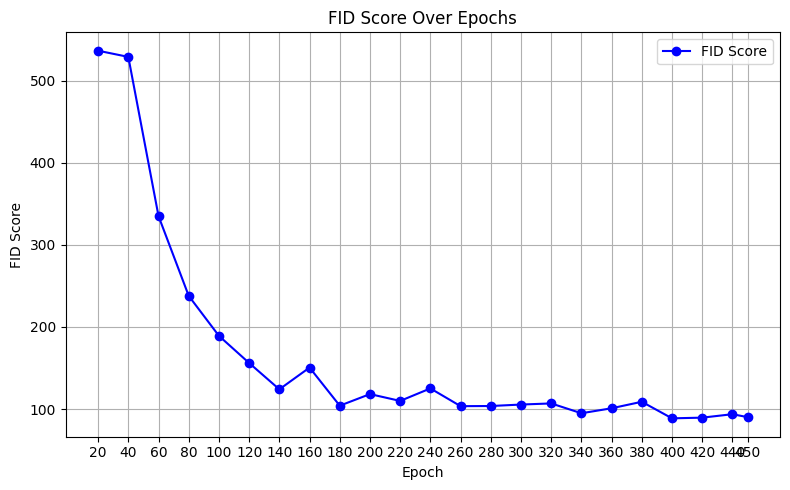

In [35]:
plot_fid(fid_scores, x_labels)
